In [160]:
# importing the necessary libraries and cleaned data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.optimize import minimize
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize

data = pd.read_csv('cleaned_data.csv')

# output the first 5 values to confirm it loaded correctly and use as reference later
data.head()

,Unnamed: 0,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


In [161]:
# Helper Functions

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost_logistic(y, y_hat):
    m = len(y) # Number of training examples
    epsilon = 1e-5 # Small constant to prevent log being 0
    # Compute the logistic regression cost
    cost = (-1 / m) * (y.T.dot(np.log(y_hat + epsilon)) + (1 - y).T.dot(np.log(1 - y_hat + epsilon)))
    return cost

def optimize_theta(theta, X, y):
    # Define the objective function to minimize
    def objective_function(t):
        # Calculate the predicted probabilities (y_hat)
        y_hat = sigmoid(X.dot(t))
        # Compute the cost with current theta, y, and y_hat
        return compute_cost_logistic(y, y_hat)
    
    # Run the optimizer with the objective function
    result = minimize(objective_function, theta, method='TNC', jac=False)
    return result.x, result.fun

In [162]:
# logisticRegression Function

# The parameter threshold = None is essentially a function overload in this implementation: 
# - if it is not provided (i.e. = None), the function will automatically loop through thresholds 0.1 to 0.9 in 0.1 increments and then output the best for accurately predicting fraud and not fraud in the format: [accuracy, threshold]
# - if a threshold is provided, then the function outputs the sigmoid function plot and confusion matrix for that threshold
# Work in progress right now, but it can also take numerous features and output the decision matrix for the given threshold
# TODO: implement string feature handling (i.e. so we can use 'merchant' as a feature)
def logisticRegression(features, title, label, threshold=None):
    # if there is only one feature, show the plot & the confusion matrix
    if (len(features) == 1):

        # 1. create the feature matrix with column of ones and second column of the feature values
        X = np.c_[np.ones(data.shape[0]), data[features]]

        # 2. extract the target variable: is_fraud
        y = data['is_fraud'].values

        # 3. split the data with 80% training and 20% testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

        # 4. show the numbers of samples
        # print("Number of samples in X_train: ", len(X_train))
        # print("Number of samples in X_test: ", len(X_test))
        # print("Number of samples in y_train: ", len(y_train))
        # print("Number of samples in y_test: ", len(y_test))

        ###

        # 1. create initial_theta array with zeroes of the same size as X_train
        initial_theta = np.zeros(X_train.shape[1])

        # 2. calculate the y_hat using the sigmoid function and initial_theta
        y_hat_train = sigmoid(X_train @ initial_theta)

        # 3. calculate the initial cost using the provided function with y_train and y_hat_train
        cost_logistic_train = round(compute_cost_logistic(y_train, y_hat_train), 2)

        #4. show the cost
        # print("Cost (logistic): ", cost_logistic_train)

        ###

        theta_optimized, cost_optimized_train = optimize_theta(initial_theta, X_train, y_train)

        # print("Optimized cost (logistic) on training set:", round(cost_optimized_train,2))
        # print("Optimized theta:", theta_optimized)

        ###

        # predict on the test set using the optimized theta
        y_hat_test = sigmoid(X_test @ theta_optimized)

        # if no threshold provided, lopp through each and output the best results
        if threshold == None:
            bestNotFraud = [0, 0]
            bestFraud = [0, 0]
            for i in np.arange(0.1, 1.0, 0.1):
                # create range of values of the city populations
                city_populations = np.linspace(data[features].min(), data[features].max(), 10000)

                # compute the linear combination of features and optimized theta
                z_values = theta_optimized[0] + theta_optimized[1] * city_populations
                
                # apply the sigmoid function to the range of city population values
                sigmoid_values = sigmoid(z_values)
                
                # classify based on the threshold
                predicted_classes_test = (y_hat_test >= i).astype(int)

                # calculate the confusion matrix
                cm_test = confusion_matrix(y_test, predicted_classes_test, normalize='true')

                # test & update best values 
                if (cm_test[0, 0] > bestNotFraud[0]):
                    bestNotFraud[0] = cm_test[0, 0] 
                    bestNotFraud[1] = i 
                if (cm_test[1, 1] > bestFraud[0]):
                    bestFraud[0] = cm_test[1, 1] 
                    bestFraud[1] = i 
            
            # print out the best values for both accurately predicted not fraud and fraud
            print(f"bestNotFraud: {bestNotFraud}")
            print(f"bestFraud: {bestFraud}")

        # else a threshold is provided, so compute and output the plot and confusion matrix
        else:
            ## Sigmoid Function Plot ##
            # plot the actual data points
            plt.figure(figsize=(14, 9))
            plt.scatter(X_test[:, 1], y_test, c=y_test, cmap='coolwarm', alpha=0.5, label='Actual Data')

            # create range of values of the city populations
            city_populations = np.linspace(data[features].min(), data[features].max(), 10000)
            # compute the linear combination of features and optimized theta
            z_values = theta_optimized[0] + theta_optimized[1] * city_populations
            # apply the sigmoid function to the range of city population values
            sigmoid_values = sigmoid(z_values)
            # Plot the sigmoid function
            plt.plot(city_populations, sigmoid_values, color='blue', label='Sigmoid Function')

            # plot the decision boundary based on the threshold
            plt.axvline(x=(np.log(threshold / (1 - threshold)) - theta_optimized[0]) / theta_optimized[1], color='green', linestyle='--', label=f'Decision Boundary (Threshold = {threshold})')
            # plot the probability threshold
            plt.axhline(threshold, color='red', linestyle='--', label=f'Probability Threshold = {threshold}')

            # add the title, labels, and legend
            plt.title(f"Sigmoid Function Applied to {title}")
            plt.xlabel(label)
            plt.ylabel('Is Not Fraud (0)    or    Is Fraud (1)')
            plt.legend()

            # show the plot
            plt.show()

            ## Confusion Matrix ##
            # classify based on the threshold
            predicted_classes_test = (y_hat_test >= threshold).astype(int)

            # calculate the confusion matrix
            cm_test = confusion_matrix(y_test, predicted_classes_test, normalize='true')

            # creates the confusion matrix
            custom_cmap = LinearSegmentedColormap.from_list("custom_map", ["#4B4B4B", "#f28328"], N = 100)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Is Not Fraud (0)", "Is Fraud (1)"])
            fig, ax = plt.subplots(figsize=(6, 6))
            im = disp.plot(cmap=custom_cmap, ax=ax, values_format="f", colorbar=False).im_

            # changes the text to be in percentage format and actually have the '%' in it
            for text in ax.texts:
                text.set_text(f"{float(text.get_text()) * 100:.2f}%")

            # add the colorbar and title
            fig.colorbar(im, ax=ax, shrink = 0.81)
            plt.title(f"Confusion Matrix for {title}")

            # show the plot
            plt.show()

    # WIP: confusion matrix for numerous features
    else:
        # 1. create the feature matrix with column of ones and second column of the feature values
        X = np.c_[np.ones(data.shape[0]), data[features]]

        # 2. extract the target variable: is_fraud
        y = data['is_fraud'].values

        # 3. split the data with 80% training and 20% testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

        # 4. show the numbers of samples
        # print("Number of samples in X_train: ", len(X_train))
        # print("Number of samples in X_test: ", len(X_test))
        # print("Number of samples in y_train: ", len(y_train))
        # print("Number of samples in y_test: ", len(y_test))

        ###

        # 1. create initial_theta array with zeroes of the same size as X_train
        initial_theta = np.zeros(X_train.shape[1])

        # 2. calculate the y_hat using the sigmoid function and initial_theta
        print(type(X_train), X_train.dtype)
        y_hat_train = sigmoid(X_train @ initial_theta)

        # 3. calculate the initial cost using the provided function with y_train and y_hat_train
        cost_logistic_train = round(compute_cost_logistic(y_train, y_hat_train), 2)

        #4. show the cost
        # print("Cost (logistic): ", cost_logistic_train)

        ###

        theta_optimized, cost_optimized_train = optimize_theta(initial_theta, X_train, y_train)

        # print("Optimized cost (logistic) on training set:", round(cost_optimized_train,2))
        # print("Optimized theta:", theta_optimized)

        ###

        # predict on the test set using the optimized theta
        y_hat_test = sigmoid(X_test @ theta_optimized)

        # classify based on the threshold
        predicted_classes_test = (y_hat_test >= threshold).astype(int)

        # calculate the confusion matrix
        cm_test = confusion_matrix(y_test, predicted_classes_test, normalize='true')

        # creates the confusion matrix
        custom_cmap = LinearSegmentedColormap.from_list("custom_map", ["#4B4B4B", "#f28328"], N = 100)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Is Not Fraud (0)", "Is Fraud (1)"])
        fig, ax = plt.subplots(figsize=(6, 6))
        im = disp.plot(cmap=custom_cmap, ax=ax, values_format="f", colorbar=False).im_

        # changes the text to be in percentage format and actually have the '%' in it
        for text in ax.texts:
            text.set_text(f"{float(text.get_text()) * 100:.2f}%")

        # add the colorbar and title
        fig.colorbar(im, ax=ax, shrink = 0.81)
        plt.title(f"Confusion Matrix for {title}")

        # show the plot
        plt.show()

bestNotFraud: [0.9940071913703555, 0.9]
bestFraud: [0.7647058823529411, 0.1]


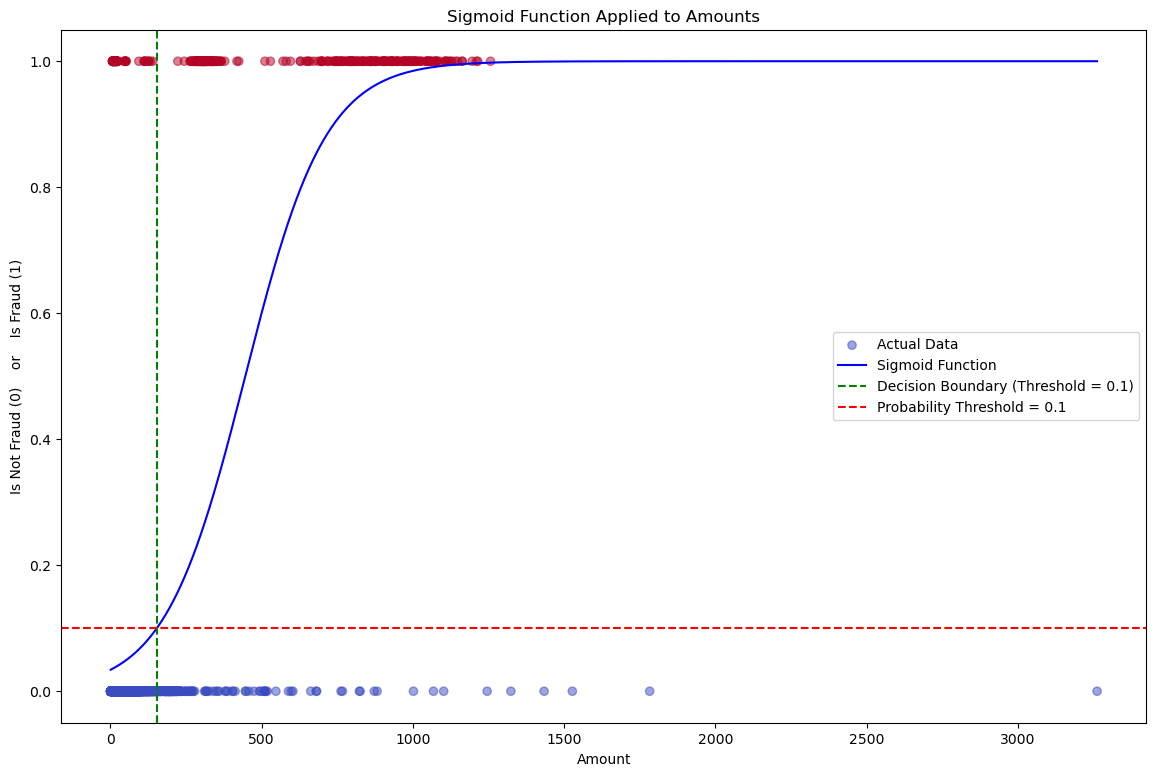

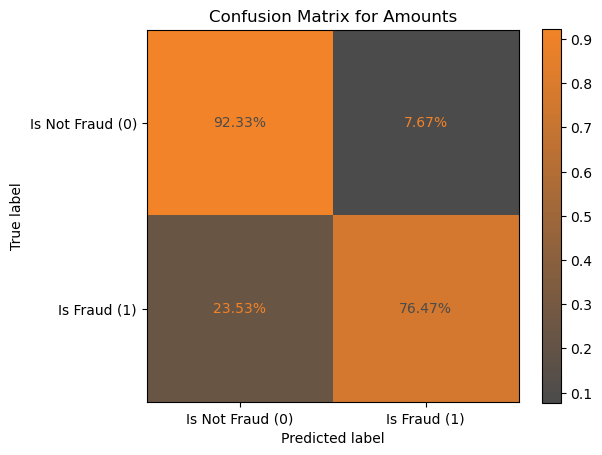

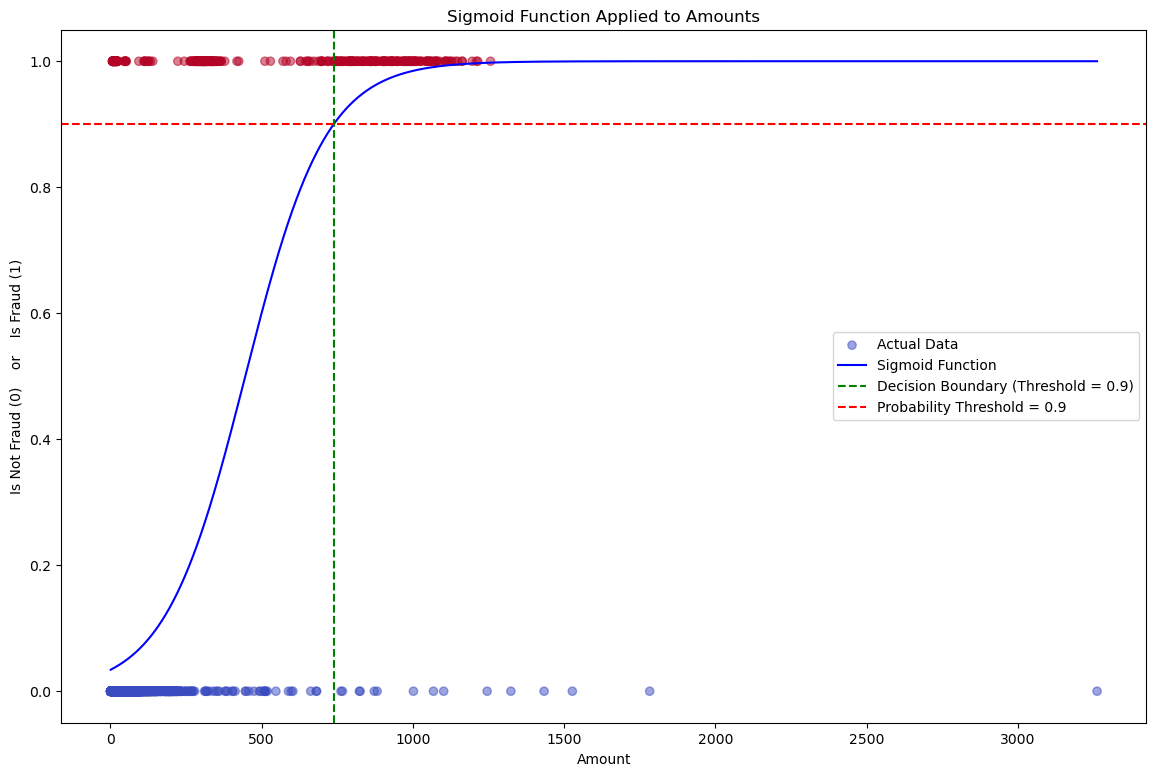

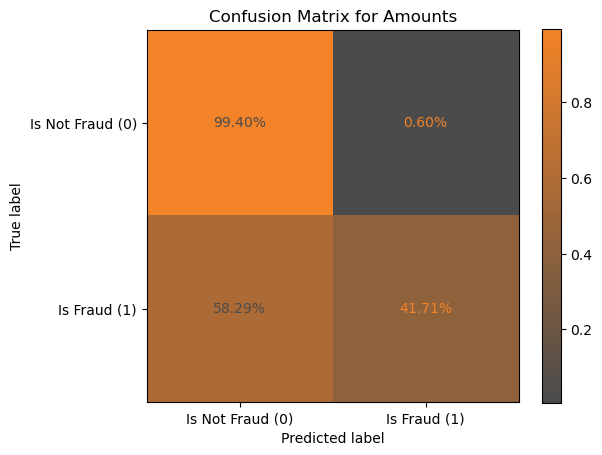

In [163]:
logisticRegression(['amt'], 'Amounts', 'Amount')

logisticRegression(['amt'], 'Amounts', 'Amount', 0.1)
logisticRegression(['amt'], 'Amounts', 'Amount', 0.9)